In [1]:
import torch
from tensorflow.keras.datasets import mnist
from matplotlib import pyplot as plt
from torchvision.transforms.functional import rotate
from scipy.linalg import lstsq, null_space

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

In [2]:
def G(d): # questa è  rot_mat
    mat = np.zeros(d**4).reshape(d**2,d**2)
    for j in range(d):
        for i in range(d):
            k = (i+1)*d-j
            h = i+(j)*d+1
#             print(h,k)
            mat[h-1][k-1] = 1
    return mat

def W(output_dim, d = 4):
    kernel = null_space((np.identity(d*d) -  G(d)).T).T
    W = []
    for j in range(output_dim):
        vec = np.zeros(d**2)
        for k in kernel:
            vec = np.random.random()*k + vec
        W.append(list(vec))
    W = np.array(W)/len(kernel)
    return np.array(W)

## Load Data

Train: X=(60000, 28, 28), y=(60000,)
Test: X=(10000, 28, 28), y=(10000,)


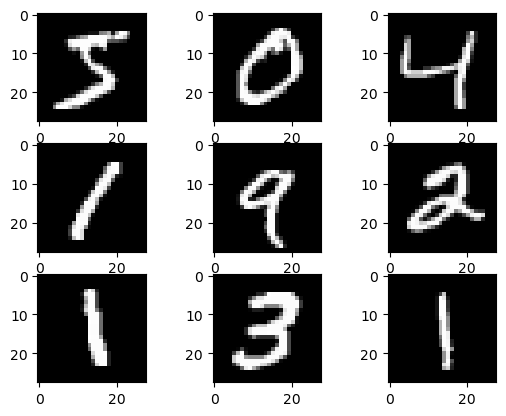

In [3]:
# load dataset
(trainX, trainy), (testX, testy) = mnist.load_data()
# summarize loaded dataset
print('Train: X=%s, y=%s' % (trainX.shape, trainy.shape))
print('Test: X=%s, y=%s' % (testX.shape, testy.shape))
# plot first few images
for i in range(9):
    # define subplot
    plt.subplot(330 + 1 + i)
    # plot raw pixel data
    plt.imshow(trainX[i], cmap=plt.get_cmap('gray'))
# show the figure
plt.show()

## Define NN

In [13]:
from torch import nn

# Get cpu or gpu device for training.
device = "cuda"
print(f"Using {device} device")

class InvariantNN(nn.Module):
    def __init__(self):
        super(InvariantNN, self).__init__()
        
#         self.softmax = nn.Softmax()
        
        self.flatten = nn.Flatten(start_dim=1)
        self.l1 = nn.Linear(28*28, 64)
        self.l2 = nn.Linear(64, 64)
        self.l3 = nn.Linear(64, 10)
        self.relu = nn.ReLU()
        
        self.acc_loss = nn.CrossEntropyLoss()
        self.inv_loss = nn.MSELoss(reduction='sum')
        
    def get_gradient(self):
        def_grad = {name: param.grad.clone() for name, param in self.named_parameters()}
        flatten_def_grad = torch.concatenate([grad.flatten() for grad in def_grad.values()])
        return(flatten_def_grad)
        
    def default_gradient(self, x0, target):
        optimizer.zero_grad()
        loss = self.acc_loss(self.forward(x0), target)
        loss.backward(retain_graph=True)  
        def_grad = {name: param.grad.clone() for name, param in self.named_parameters()}
        flatten_def_grad = torch.concatenate([grad.flatten() for grad in def_grad.values()])
        return def_grad, flatten_def_grad
    
    def invariance_gradient(self, x0, x0_r, target):
        optimizer.zero_grad()
        invariance_loss = self.inv_loss(x0, x0_r)
        print(invariance_loss)
        invariance_loss.requires_grad = True
        invariance_loss.backward(retain_graph=True)
        inv_grad = {name: param.grad.clone() for name, param in self.named_parameters()}
        flatten_inv_grad = torch.concatenate([grad.flatten() for grad in inv_grad.values()])
        return inv_grad, flatten_inv_grad

    def project_gradient(self, scalar, norm, def_grad, inv_grad):
        
        with torch.no_grad():
            for name, param in self.named_parameters():
                if param.grad is not None:
                    param.grad = def_grad[name] - (scalar/(norm**2))*inv_grad[name]
        return {name: param.grad.clone() for name, param in self.named_parameters()}
    
    def retraction(self, x0, x0_r):

        retraction_loss = (self.inv_loss(x0, x0_r))**2/2
        retraction_loss.backward()
        norm = self.get_gradient().norm()**2
        optimizer_manifold = torch.optim.SGD(model.parameters(), lr=1/(2*norm), momentum=0)
        return torch.optim.SGD(model.parameters(), lr=1/(2*norm), momentum=0)
        

    def forward(self, x):
        x = self.flatten(x)
        x = self.l1(x)
        x = self.relu(x)
        x = self.l2(x)    
        x = self.relu(x)
        x = self.l3(x)
        x = self.relu(x)
#         x = self.softmax(x)
        return  x
    
    
# print(model)

Using cuda device


In [14]:
model.inv_loss(x0,rotated_data_90)

tensor(4.4614e+11, device='cuda:0')

In [ ]:
model = InvariantNN().to(device)
model.l1.weight.data = torch.Tensor(W(64,d = 28)).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-5, momentum=0)

x0 = torch.Tensor(trainX).to(device) # images 
y0 = torch.Tensor(trainy).to(device) # true labels in form [0,0,0,1,0,0,0,0,0,0]

rotated_data_90 = rotate(img = x0, angle = 90)

## Gradient projection train

In [7]:
model = InvariantNN().to(device)
model.l1.weight.data = torch.Tensor(W(64,d = 28)).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-5, momentum=0)

x0 = torch.Tensor(trainX).to(device) # images 
y0 = torch.Tensor(trainy).to(device) # true labels in form [0,0,0,1,0,0,0,0,0,0]

rotated_data_90 = rotate(img = x0, angle = 90)
rotated_data_180 = rotate(img = x0, angle = 180)
rotated_data_270 = rotate(img = x0, angle = 270)

loss_accuracy = []
accuracy = []

loss_invariance = []
invariance = []

for i in range(1000):
    
    pred1 = model(x0)
    pred2 = model(rotated_data_90)
    pred3 = model(rotated_data_180)
    pred4 = model(rotated_data_270)
    
    _, pred_label1 = torch.max(pred1,1)
    _, pred_label2 = torch.max(pred2,1)
    _, pred_label3 = torch.max(pred3,1)
    _, pred_label4 = torch.max(pred4,1)
    
    
    acc = (pred_label1 == y0.long()).sum().item()/len(x0)
    inv_1 = (pred_label1 == pred_label2).sum().item()/len(x0)
    inv_2 = (pred_label1 == pred_label3).sum().item()/len(x0)
    inv_3 = (pred_label1 == pred_label4).sum().item()/len(x0)
    
    inv = (inv_1 +inv_2 + inv_3)/3
    
    accuracy_loss = model.acc_loss(pred1, y0.long())
    invariance_loss = model.inv_loss(pred1, pred2)
    
    if i%2 == 1:
        optimizer.zero_grad()
        epsilon = model.retraction(pred1, pred2)
        epsilon.step()
    else:
        def_grad, flat_def_grad = model.default_gradient(x0, y0.long())
        inv_grad, flat_inv_grad = model.invariance_gradient(x0, rotated_data_90, y0.long())

        scalar = torch.dot(flat_def_grad, flat_inv_grad)
        norm = torch.norm(flat_inv_grad)
        model.project_gradient(scalar, norm, def_grad, inv_grad)
        optimizer.step()


    if (i%100 == 0):
        print("###########", i, "############")
        print("Accuracy: " , round(acc, 2))
        print("Invariance: ", round(inv, 2))
        print("Loss: " , accuracy_loss.cpu().detach().numpy())
        print("Invariance_loss: " , invariance_loss.cpu().detach().numpy())


    loss_accuracy.append(accuracy_loss.cpu().detach().numpy())
    loss_invariance.append(invariance_loss.cpu().detach().numpy())
    accuracy.append(acc)
    invariance.append(inv)

tensor(4.4614e+11, device='cuda:0')


RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

In [ ]:
model = InvariantNN().to(device)
model.l1.weight.data = torch.Tensor(W(64,d = 28)).to(device)
pred1 = model(x0)
pred2 = model(rotated_data_90)
y0 = torch.Tensor(trainy).to(device)
inv_loss = (model.loss(pred1, y0.long()) - model.loss(pred2, y0.long()))**2/2
print(inv_loss.cpu().detach().numpy())

In [ ]:
cm = confusion_matrix(y0.long().cpu(), pred_label1.cpu())
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [ ]:
rotated_data = rotate(img = x0, angle = 270)

pred1 = model(x0)
pred2 = model(rotated_data)
_, arg1 = torch.max(pred1,1)
_, arg2 = torch.max(pred2,1)

cm = confusion_matrix(arg1.cpu(), arg2.cpu())
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.xlabel("rotated image")
plt.ylabel("default image")
plt.show()

In [ ]:
f = plt.figure(1)
# plt.plot(loss_history, label = "loss")
plt.plot(np.abs(loss_invariance), label = "invariance_loss")
plt.legend()
f.show()
g = plt.figure(2)
plt.plot(accuracy, label = "accuracy")
plt.plot(invariance, label = "invariance")
plt.legend()
g.show()

Due obiettivi:
* siamo entrati nella manifold (nessuno si è accorto di noi)
* 

## Root finding

In [ ]:
from scipy import optimize

In [ ]:
plt.imshow((x0[0] - rotate(img = x0, angle = 270))[0])

In [ ]:
plt.imshow((x0[0] - rotate(img = x0, angle = 45))[0])

In [ ]:
scipy.linalg.
lstsq
scipy.linalg.lstsq

In [ ]:
# Definisci la matrice A
A = np.array([[2, 4], [1, 2]])

# Calcola il kernel
kernel = null_space(A)
print("Kernel della matrice:")
print(kernel.flatten())


In [ ]:
Weights = W(5,rot_mat(28))

In [ ]:
image1 = model.flatten(x0[0:1]).detach().numpy()[0]
image1_rot = model.flatten(rotate(img = x0[0:1], angle = 90)).detach().numpy()[0]

In [ ]:
out1 = Weights@image1
out2 = Weights@image1_rot

In [ ]:
out1

In [ ]:
out2

In [ ]:
out1-out2

In [ ]:
x_vec = x.reshape(16)
x_r = mat@x_vec
x_r_img = x_r.reshape(4,4)
plt.imshow(x_r_img)

## Train

# Standard train

In [ ]:
model = InvariantNN()
# model.l1.weight.data = torch.Tensor(W(64,rot_mat(28)))
optimizer = torch.optim.SGD(model.parameters(), lr=1e-4, momentum=0.9)

x0 = torch.Tensor(trainX)
y0 = torch.Tensor(trainy)

rotated_data = rotate(img = x0, angle = 110)
loss_history = []
accuracy = []

for i in range(400):
    l_inv = 0
    l_acc = 1
    optimizer.zero_grad()
    
    pred1 = model(x0)
    pred2 = model(rotated_data)
    avg_pred = torch.sum(pred1, axis = 0)/6000
    
    _, arg1 = torch.max(pred1,1)
    _, arg2 = torch.max(pred2,1)
    
    
    acc = (arg1 == y0.long()).sum().item()/len(x0)
    inv = (arg1 == arg2).sum().item()/len(x0)   
    
    loss = loss_CE(pred1, y0.long()) #- 0.001*loss_CE( avg_pred , uniform_dist )
    
    
    if i%5 == 1:
        print("Accuracy: " , round(acc, 2))
        print("Invariance: ", round(inv, 2))
        print("Loss: " , loss.detach().numpy())
          
    loss_history.append(loss.detach().numpy())
    accuracy.append(acc)
    
    loss.backward()
    optimizer.step()

In [ ]:
model = InvariantNN()
model.l1.weight.data = torch.Tensor(W(64,28))

x0 = torch.Tensor(trainX)
y0 = torch.Tensor(trainy)

rotated_data = rotate(img = x0, angle = 270)

pred1 = model(x0)
pred2 = model(rotated_data)
avg_pred = torch.sum(pred1, axis = 0)/6000

_, arg1 = torch.max(pred1,1)
_, arg2 = torch.max(pred2,1)

acc = (arg1 == y0.long()).sum().item()/len(x0)
inv = (arg1 == arg2).sum().item()/len(x0) 
loss = loss_CE(pred1, pred2) + loss_CE(pred1, y0.long()) #- 0.001*loss_CE( avg_pred , uniform_dist )

print("Accuracy: " , round(acc, 5))
print("Invariance: ", round(inv, 9))
print("Loss: " , loss.detach().numpy())

cm = confusion_matrix(arg1, arg2)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

# Definizione di una rete neurale di esempio
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.linear1 = nn.Linear(10, 5)
        self.linear2 = nn.Linear(5, 1)
    
    def forward(self, x):
        x = torch.relu(self.linear1(x))
        return self.linear2(x)

# Funzione per concatenare i gradienti di tutti i parametri in un unico vettore
def get_concatenated_gradients(grad_dict):
    return torch.cat([g.flatten() for g in grad_dict.values() if g is not None])

# Funzione per ricostruire i gradienti dai vettori concatenati
def set_gradients_from_vector(model, grad_vector, grad_dict):
    offset = 0
    for name, param in model.named_parameters():
        if grad_dict[name] is not None:
            grad_shape = grad_dict[name].shape
            grad_size = grad_dict[name].numel()
            param.grad = grad_vector[offset:offset + grad_size].view(grad_shape)
            offset += grad_size

# Inizializziamo il modello e l'ottimizzatore
model = SimpleNN()
optimizer = optim.SGD(model.parameters(), lr=0.01)

# Creiamo due insiemi di input differenti
x1 = torch.randn(3, 10)
x2 = torch.randn(3, 10)

# Creiamo dei target casuali per calcolare la loss
target1 = torch.randn(3, 1)
target2 = torch.randn(3, 1)

# STEP 1: Calcolo dei gradienti rispetto ai pesi per il primo input `x1`
output1 = model(x1)
loss1 = nn.functional.mse_loss(output1, target1)
optimizer.zero_grad()
loss1.backward(retain_graph=True)
grads1 = {name: param.grad.clone() for name, param in model.named_parameters()}

# STEP 2: Calcolo dei gradienti rispetto ai pesi per il secondo input `x2`
output2 = model(x2)
loss2 = nn.functional.mse_loss(output2, target2)
optimizer.zero_grad()
loss2.backward()
grads2 = {name: param.grad.clone() for name, param in model.named_parameters()}

# Concateniamo i gradienti in un unico vettore
grad1_vec = get_concatenated_gradients(grads1)
grad2_vec = get_concatenated_gradients(grads2)

# STEP 3: Calcolo della componente ortogonale di `grad1_vec` rispetto a `grad2_vec`
with torch.no_grad():
    dot_product = torch.dot(grad1_vec, grad2_vec)
    norm_grad2_sq = torch.norm(grad2_vec) ** 2

    # Evitiamo la divisione per zero
    if norm_grad2_sq > 0:
        # Calcoliamo la proiezione di `grad1_vec` su `grad2_vec`
        projection = (dot_product / norm_grad2_sq) * grad2_vec
        # Calcoliamo la componente ortogonale
        ortho_component = grad1_vec - projection
    else:
        ortho_component = grad1_vec

    # Ricostruiamo i gradienti nel modello usando la componente ortogonale
    set_gradients_from_vector(model, ortho_component, grads1)

# STEP 4: Eseguiamo l'aggiornamento dei pesi usando la componente ortogonale
optimizer.step()

# Stampa dei pesi aggiornati (opzionale)
print("Pesi aggiornati:")
for name, param in model.named_parameters():
    print(f"{name}: {param.data}")
